In [1]:
import time
import os
import glob
import numpy  as np
import tables as tb
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib widget

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer

In [2]:
plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

# PSF Class and Functions

In [3]:
class PSF:
    def __init__(self, datadir, get_file_number, nfiles, EL_gap=10, dmax=510, detector_db="flex100", dz=1, dd=1, psf_config=None):
        self.datadir = datadir
        self.get_file_number = get_file_number
        self.el_gap_width = EL_gap
        self.dmax = dmax
        self.detector_db = detector_db
        self.nfiles = nfiles
        self.nphotons_in_file = []
        self.dz = dz
        self.dd = dd
        
        self.filenames = self._get_filenames(self.datadir, self.get_file_number)
        self.zbins, self.dbins = self._binning(self.el_gap_width, self.dmax, self.dz, self.dd)
        self.dfs, self.nevents = self._dfdict(self.dbins, self.zbins)
        self.datasipm = self._dataSiPM(self.detector_db)
        
        if psf_config != None:
            self.psf         = psf_config[0]
            self.config      = psf_config[1]
            run              = self.config.loc[8, "value"]
            SiPMconfig       = self.config.loc[7, "value"]
            self.run         = run
            self.sipm_config = SiPMconfig
            print("You have succesfully uploaded an existing PSF.")
        
    def _get_filenames(self, datadir, get_file_number):
        filenames = sorted(glob.glob(datadir + "*.h5"), key=get_file_number)
        return filenames
    
    def _binning(self, el_gap_width, dmax, dz, dd):
        # Configure z binning  
        zbins = np.arange(0, el_gap_width + dz, dz)

        # Configure transverse binning
        dbins = np.arange(0, dmax + dd, dd)
        
        return zbins, dbins
    
    def _dfdict(self, dbins, zbins):
        # dbin DataFrame
        df = pd.DataFrame()
        df["d_bin"]   = dbins[:-1]
        df["charge"]  = np.zeros(len(dbins)-1)
        df["entries"] = np.zeros(len(dbins)-1)
        df = df.set_index("d_bin")

        # Number of events and DataFrame dictionaries
        dfs = dict()
        nevents = dict()
        for z in zbins[:-1]: 
            dfs[z] = df.copy()
            nevents[z] = 0

        return dfs, nevents
    
    def _dataSiPM(self, detector_db):
        datasipm = load_db.DataSiPM(detector_db, 0)
        return datasipm
        
    def fill_dfs(self):
        t0 = time.time()
        for i, filename in enumerate(self.filenames[:self.nfiles]):

            print("Processing file:", i+1, "/", len(self.filenames), end="\r")

            configuration = pd.read_hdf(filename, "/MC/configuration").set_index("param_key")
            particles     = pd.read_hdf(filename, "/MC/particles/")
            sns_response  = pd.read_hdf(filename, "/MC/sns_response")
            sns_positions = pd.read_hdf(filename, "/MC/sns_positions")

            Nphotons = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])  # Finds # photons in filename.
            self.nphotons_in_file.append(Nphotons)

            # Select SIPMs
            sns_response = sns_response[np.isin(sns_response["sensor_id"], self.datasipm["SensorID"])] # Checks (element-wise) whether the "sensor_id" response is in the datasipm["SensorID"] array. If True, it keeps the corresponding sns_response element.
            for event_id, particle in particles.groupby("event_id"):
                x = particle["initial_x"].values
                y = particle["initial_y"].values
                z = particle["initial_z"].values

                # Distances from emission point
                distances_df          = pd.DataFrame.copy(self.datasipm.drop(["ChannelID", "adc_to_pes", "Sigma"], axis=1))
                distances_df["d"]     = ((distances_df["X"]-x)**2 + (distances_df["Y"]-y)**2)**0.5  # Calculates distance of particle to every SiPM.
                distances_df["d_bin"] = pd.cut(distances_df["d"], bins=self.dbins, labels=self.dbins[:-1], include_lowest=True)  # Places each distance into one of the 100 distance bins.
                distances_df          = distances_df.set_index("SensorID")  # Organize each distance by SensorID.
                
                responses = sns_response[sns_response["event_id"]==event_id] # Only keeps the responses of the given event.

                # Charge per sensor
                charges = responses.groupby("sensor_id")["charge"].sum() # Sum all the charge registered by each sensor throughout the whole event.
                charges = charges.reindex(self.datasipm["SensorID"], fill_value=0) # Organize charges by SensorID.

                distances_df["charge"] = charges  # Add charges to distances DataFrame.
                total_charge = distances_df.groupby("d_bin")["charge"].sum()  # Calculate total charge within a given distance (transverse) bin.
                entries      = distances_df.groupby("d_bin")["d"]     .nunique()  # Counts the number of distinct elements within each dbin.

                # Fill total df
                zbin = pd.cut(-z, bins=self.zbins, labels=self.zbins[:-1])[0]
                if np.isnan(zbin): continue

                df = self.dfs[zbin]
                df["charge"]  = df["charge"]  + total_charge  # Update total charge for each zbin's DataFrame.
                df["entries"] = df["entries"] + entries  # Update total entries for each zbin's DataFrame.
                self.dfs[zbin] = df

                self.nevents[zbin] += 1  # How many events are within each zbin?

        self.nphotons_in_file = np.array(self.nphotons_in_file)
        Nphotons = self.nphotons_in_file[0]
        assert np.all(self.nphotons_in_file == Nphotons)  # Check that all files had the same number of photons.

        print(f"Time (total {sum(list(self.nevents.values()))} events):", (time.time()-t0)/60.)
        
    def calculatePSF(self, run : str, SiPMconfig : str, signal_type="S2", verbosity=False):
        psf = pd.DataFrame()
        for zbin in self.dfs:
            Nphotons  = self.nphotons_in_file[0]
            Charge    = self.dfs[zbin]["charge"]
            Entries   = self.dfs[zbin]["entries"]
            PSF_Value = Charge/Entries/Nphotons
            PSF_Value = PSF_Value.fillna(0)
            psf[zbin] = PSF_Value
            if verbosity:
                print(f"Z bin: {zbin}")
                print(f"  Charge:            {Charge}\n")
                print(f"  Entries:           {Entries}\n")
                print(f"  Number of Photons: {Nphotons}\n")
                print(f"  PSF Value:         {PSF_Value}\n")
        
        # Configuration Parameters.
        for i, zbin in enumerate(self.zbins[:-1]):
            psf = psf.rename({zbin: "z_m" + str(int(self.zbins[i+1]))}, axis=1)

        psf = psf.reset_index().rename({"d_bin": "dist_xy"}, axis=1)
        
        self.psf = psf
        self.run = run
        self.sipm_config = SiPMconfig
        
        self.createConfig(self.detector_db, signal_type)
        
    
    def savePSF(self, outdir=None):
        if hasattr(self, "psf"):
            outfilename = f"NextFlex-Run{self.run}-SiPM{self.sipm_config}_PSF.h5"
            if outdir != None:
                outdir = outdir + outfilename
            else:
                outdir = outfilename
            with tb.open_file(outdir, 'w') as h5out:
                df_writer(h5out, self.psf, 'PSF',  'LightTable')
                
            self.saveConfig(outdir)
        else:
            raise AttributeError("No PSF stored in object. You must calculate or upload the PSF before saving.")
            
    def createConfig(self, detector, signal_type, active_rad=492):
        # Create config
        config = { "detector"   : detector
                 , "ACTIVE_rad" : str(active_rad)  # 984.0 mm / 2
                 , "EL_GAP"     : str(self.el_gap_width)
                 , "table_type" : "energy"
                 , "signal_type": signal_type
                 , "sensor"     : "SiPM"
                 , "pitch_z"    : str(self.dz)
                 , "SiPM_config": self.sipm_config
                 , "Run"        : self.run}

        config = pd.DataFrame({"parameter": list(config.keys()), "value": list(config.values())})
        # config = config.set_index("parameter") Leave commented or saveConfig will fail.
        self.config = config
        
    def saveConfig(self, outdir):
        if hasattr(self, "config"):
            # outfilename = f"NextFlex-Run{self.run}-SiPM{self.sipm_config}_PSF.h5"
            with tb.open_file(outdir, 'r+') as h5out:
                df_writer(h5out, self.config, "PSF", "Config")
        else:
            raise AttributeError("No configuration file stored in object. You must create the configuration file before saving.")
            
    def calculateProbability(self):
        columns_list = list(self.psf)
        columns_list.remove("dist_xy")
        dectProb = self.psf[columns_list].mean(axis=1)
        self.probability = dectProb

# PSF Calculations:

## SiPM Size: 1.3mm, Pitch: 15.55mm. Database: "flex100".

In [4]:
# Upload existing PSF
size1_3_pitch15_55_psf    = load_dst("/mnt/c/Harvard/PSF/PSF_HDF5/NextFlex-Run1-SiPM1.3mmSize_15.55mmPitch_PSF.h5",
                                     "PSF", "LightTable")
size1_3_pitch15_55_config = load_dst("/mnt/c/Harvard/PSF/PSF_HDF5/NextFlex-Run1-SiPM1.3mmSize_15.55mmPitch_PSF.h5",
                                     "PSF", "Config")
size1_3_pitch15_55_psf_config = [size1_3_pitch15_55_psf, size1_3_pitch15_55_config]

In [5]:
# PSF Class Initialization.
size1_3_pitch15_55 = PSF(datadir         = r"/mnt/c/Harvard/PSF/1.3mmS_15.5mmP/2022_02_10/",
                         get_file_number = lambda filename: int(filename.split("/")[-1].split(".")[3]),
                         nfiles          = 100,
                         detector_db     = "flex100",
                         psf_config      = size1_3_pitch15_55_psf_config)

You have succesfully uploaded an existing PSF.


In [6]:
# PSF Calculate and Save. Only run if no PSF is prevously uploaded.
size1_3_pitch15_55.fill_dfs()
size1_3_pitch15_55.calculatePSF(run="1",SiPMconfig="1.3mmSize_15.55mmPitch", verbosity=False)
size1_3_pitch15_55.savePSF(outdir="/mnt/c/Harvard/PSF/PSF_HDF5/")

Time (total 10000 events): 2.456851617495219


In [6]:
# PSF Probability.
size1_3_pitch15_55.calculateProbability()

## SiPM Size: 1.3mm, Pitch: 15.00mm. Database: "flexs13p15".

In [7]:
# Upload existing PSF
size1_3_pitch15_00_psf    = load_dst("/mnt/c/Harvard/PSF/PSF_HDF5/NextFlex-Run1-SiPM1.3mmSize_15.00mmPitch_PSF.h5",
                                     "PSF", "LightTable")
size1_3_pitch15_00_config = load_dst("/mnt/c/Harvard/PSF/PSF_HDF5/NextFlex-Run1-SiPM1.3mmSize_15.00mmPitch_PSF.h5",
                                     "PSF", "Config")
size1_3_pitch15_00_psf_config = [size1_3_pitch15_00_psf, size1_3_pitch15_00_config]

In [8]:
# PSF Class Initialization.
size1_3_pitch15_00 = PSF(datadir         = r"/mnt/c/Harvard/PSF/1.3mmS_15.0mmP/",
                         get_file_number = lambda filename: int(filename.split("/")[-1].split(".")[3]),
                         nfiles          = 100,
                         detector_db     = "flexs13p15",
                         psf_config      = size1_3_pitch15_00_psf_config)

You have succesfully uploaded an existing PSF.


In [8]:
# PSF Calculate and Save.
size1_3_pitch15_00.fill_dfs()
size1_3_pitch15_00.calculatePSF(run="1",SiPMconfig="1.3mmSize_15.00mmPitch", verbosity=False)
size1_3_pitch15_00.savePSF(outdir="/mnt/c/Harvard/PSF/PSF_HDF5/")

Time (total 10000 events): 2.4766779859860737


In [9]:
# PSF Probability.
size1_3_pitch15_00.calculateProbability()

## SiPM Size: 1.0mm, Pitch: 15.00mm. Database: "flexs13p15".

In [10]:
# Upload existing PSF
size1_0_pitch15_00_psf    = load_dst("/mnt/c/Harvard/PSF/PSF_HDF5/NextFlex-Run1-SiPM1.0mmSize_15.00mmPitch_PSF.h5",
                                     "PSF", "LightTable")
size1_0_pitch15_00_config = load_dst("/mnt/c/Harvard/PSF/PSF_HDF5/NextFlex-Run1-SiPM1.0mmSize_15.00mmPitch_PSF.h5",
                                     "PSF", "Config")
size1_0_pitch15_00_psf_config = [size1_0_pitch15_00_psf, size1_0_pitch15_00_config]

In [11]:
# PSF Class Initialization.
size1_0_pitch15_00 = PSF(datadir         = r"/mnt/c/Harvard/PSF/1.0mmS_15.0mmP/",
                         get_file_number = lambda filename: int(filename.split("/")[-1].split(".")[1]),
                         nfiles          = 100,
                         detector_db     = "flexs13p15",
                         psf_config      = size1_0_pitch15_00_psf_config)

You have succesfully uploaded an existing PSF.


In [10]:
# PSF Calculate and Save.
size1_0_pitch15_00.fill_dfs()
size1_0_pitch15_00.calculatePSF(run="1",SiPMconfig="1.0mmSize_15.00mmPitch", verbosity=False)
size1_0_pitch15_00.savePSF(outdir="/mnt/c/Harvard/PSF/PSF_HDF5/")

Time (total 10000 events): 2.451374046007792


In [12]:
# PSF Probability.
size1_0_pitch15_00.calculateProbability()

# PSF Plots:

## PSF Plot Functions

In [13]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [14]:
def PSF_plot(dbins, probabilities, Label, Title=None, figSize=(10,9), Color="green"):
    fig, ax = plt.subplots(figsize=figSize)
    ax.set_xlabel("Distance (mm)")
    ax.set_ylabel("Detection Probability")
    if Title != None: ax.set_title(Title)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    assert len(dbins) == len(probabilities)
    ax.plot(dbins, probabilities, label=Label, color=Color)
    
    ax.legend()
    
    save = input("Do you wish to save this figure? [y/n] ")
    if save == "y":
        outdir = input("Please provide output directory for this figure: ")
        name   = input("Please provide a name for this figure: ")
        fig.savefig(outdir + name)

In [15]:
def PSF_multiple(dbins : list, probabilities : list, Labels, color_map_name, Title=None, figSize=(10,9)):
    fig, ax = plt.subplots(figsize=figSize)
    ax.set_xlabel("Distance (mm)")
    ax.set_ylabel("Detection Probability")
    if Title != None: ax.set_title(Title)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    if type(color_map_name) == str:
        # Color settings.
        nplots = len(dbins)
        values = range(nplots)
        color_map = plt.get_cmap(color_map_name)
        cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=color_map)

        for idx, dist in enumerate(dbins):
            ax.plot(dist, probabilities[idx], color=scalarMap.to_rgba(values[idx]), label=Labels[idx])
    
    elif type(color_map_name) == list:
        for idx, dist in enumerate(dbins):
            ax.plot(dist, probabilities[idx], color=color_map_name[idx], label=Labels[idx])
    
    ax.legend()
    save = input("Do you wish to save this figure? [y/n] ")
    if save == "y":
        outdir = input("Please provide output directory for this figure: ")
        name   = input("Please provide a name for this figure: ")
        fig.savefig(outdir + name)

In [16]:
def PSF_mosaic(dbins, probabilities, Labels, color_map_name : str, figure_mosaic, Title=None, figSize=(10,9)):
    assert len(dbins) == len(probabilities)
    
    fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=figSize)  # axes is a dict with label->ax.
    if Title != None: fig.suptitle(Title, fontsize=16)
    
    for ax in list(axes.values()):
        ax.set_xlabel("Distance (mm)")
        ax.set_ylabel("Detection Probability")
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    # Color settings.
    nplots = len(dbins)
    values = range(nplots)
    color_map = plt.get_cmap(color_map_name)
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=color_map)
    
    for idx, dist in enumerate(dbins):
        axes["A"].plot(dist, probabilities[idx], color=scalarMap.to_rgba(values[idx]), label=Labels[idx])

    axes["A"].legend()
    for ax_label, ax in axes.items():
        idx = 0
        if ax_label == "A":
            continue
        else:
            ax.plot(dbins[idx], probabilities[idx], color=scalarMap.to_rgba(values[idx]), label=Labels[idx])
            ax.legend()
        idx += 1
    
    save = input("Do you wish to save this figure? [y/n] ")
    if save == "y":
        outdir = input("Please provide output directory for this figure: ")
        name   = input("Please provide a name for this figure: ")
        fig.savefig(outdir + name)

## PSF Final Plots

### SiPM Size: 1.3mm, Pitch: 15.55mm. Single Plot

In [26]:
# Optional: Export dbins and probability values.
df_plot_size1_3_pitch15_55 = pd.DataFrame({"dbins": size1_3_pitch15_55.dbins[:-1], 
                                           "probabilities": size1_3_pitch15_55.probability.values})
df_plot_size1_3_pitch15_55.to_csv("/mnt/c/Harvard/PSF/CSV/size1_3_pitch15_55_dbins_probabilities.csv")

In [22]:
import scipy.integrate

integral1 = integrate.simps(size1_3_pitch15_55.probability.values, x=size1_3_pitch15_55.dbins[:-1])
integral2 = integrate.simps(size1_3_pitch15_00.probability.values, x=size1_3_pitch15_00.dbins[:-1])
integral3 = integrate.simps(size1_0_pitch15_00.probability.values, x=size1_0_pitch15_00.dbins[:-1])

print(integral1)
print(integral2)
print(integral3)

0.00190681317695732
0.0019054269912686331
0.0009904962527094215


Do you wish to save this figure? [y/n] y
Please provide output directory for this figure: /mnt/c/Harvard/PSF/Plots/
Please provide a name for this figure: Size1_3_Pitch15_55_Single


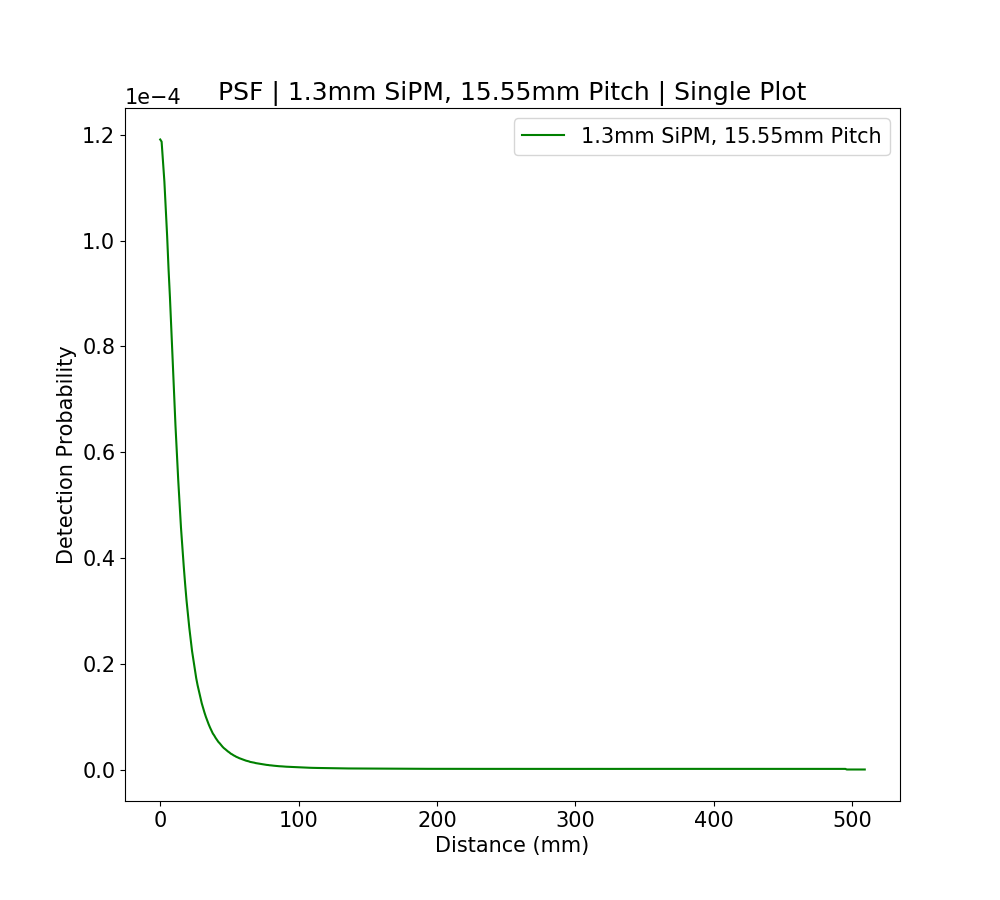

In [19]:
PSF_plot(size1_3_pitch15_55.dbins[:-1], 
         size1_3_pitch15_55.probability.values, 
         "1.3mm SiPM, 15.55mm Pitch",
         Color = "green",
         Title = "PSF | 1.3mm SiPM, 15.55mm Pitch | Single Plot")

### SiPM Size: 1.3mm, Pitch: 15.00mm. Single Plot

In [27]:
# Optional: Export dbins and probability values.
df_plot_size1_3_pitch15_00 = pd.DataFrame({"dbins": size1_3_pitch15_00.dbins[:-1], 
                                           "probabilities": size1_3_pitch15_00.probability.values})
df_plot_size1_3_pitch15_00.to_csv("/mnt/c/Harvard/PSF/CSV/size1_3_pitch15_00_dbins_probabilities.csv")

Do you wish to save this figure? [y/n] y
Please provide output directory for this figure: /mnt/c/Harvard/PSF/Plots/
Please provide a name for this figure: Size1_3_Pitch15_00_Single


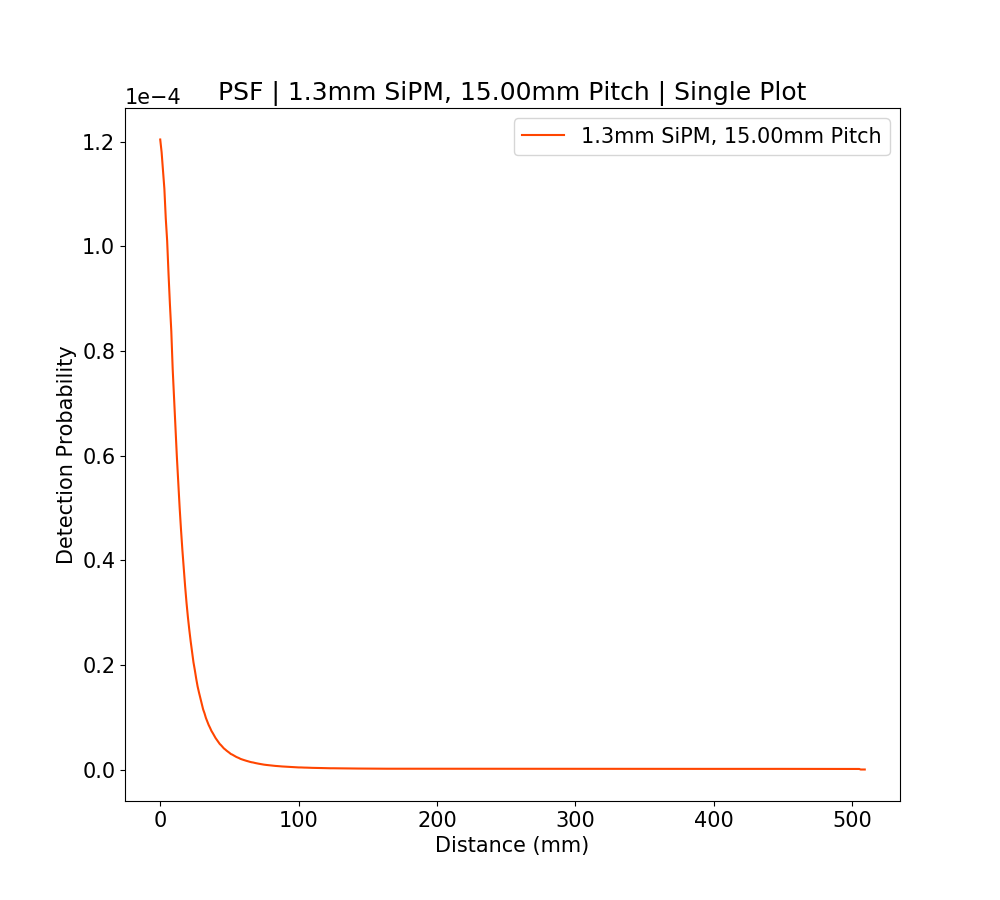

In [21]:
PSF_plot(size1_3_pitch15_00.dbins[:-1], 
         size1_3_pitch15_00.probability.values, 
         "1.3mm SiPM, 15.00mm Pitch",
         Color = "orangered",
         Title = "PSF | 1.3mm SiPM, 15.00mm Pitch | Single Plot")

### SiPM Size: 1.0mm, Pitch: 15.00mm. Single Plot

In [28]:
# Optional: Export dbins and probability values.
df_plot_size1_0_pitch15_00 = pd.DataFrame({"dbins": size1_0_pitch15_00.dbins[:-1], 
                                           "probabilities": size1_0_pitch15_00.probability.values})
df_plot_size1_0_pitch15_00.to_csv("/mnt/c/Harvard/PSF/CSV/size1_0_pitch15_00_dbins_probabilities.csv")

Do you wish to save this figure? [y/n] y
Please provide output directory for this figure: /mnt/c/Harvard/PSF/Plots/
Please provide a name for this figure: Size1_0_Pitch15_00_Single


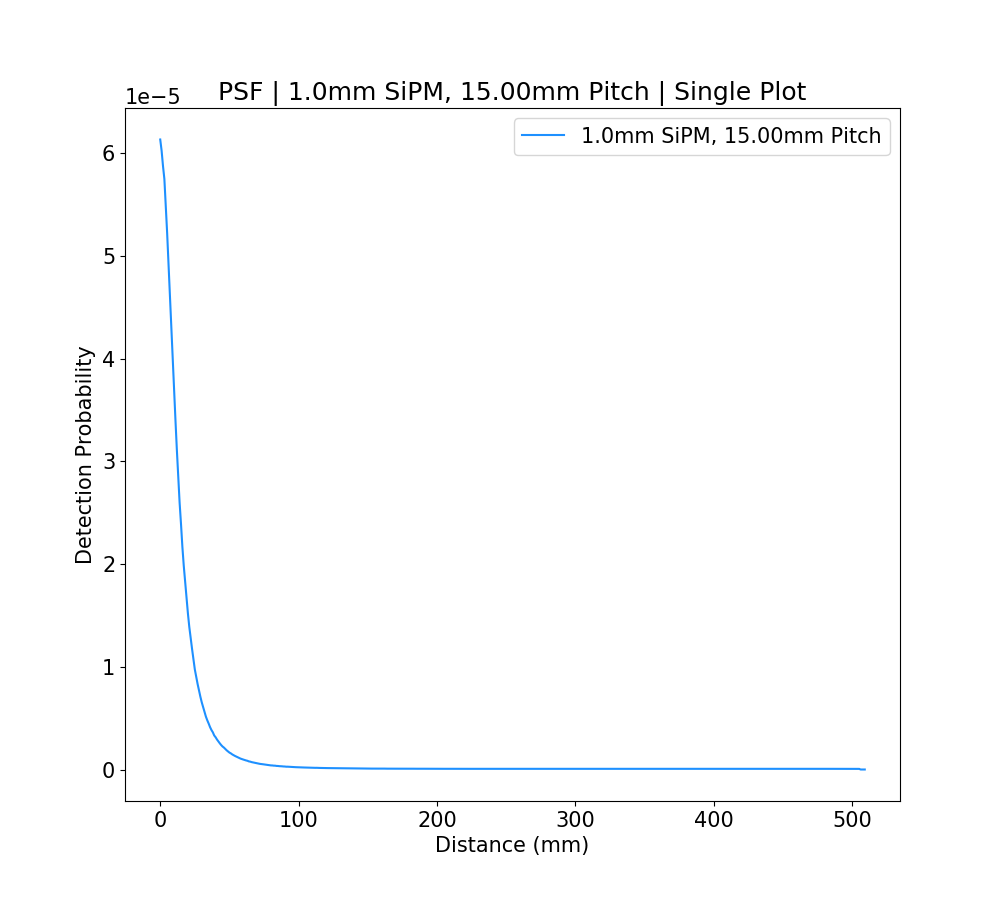

In [23]:
PSF_plot(size1_0_pitch15_00.dbins[:-1], 
         size1_0_pitch15_00.probability.values, 
         "1.0mm SiPM, 15.00mm Pitch",
         Color = "dodgerblue",
         Title = "PSF | 1.0mm SiPM, 15.00mm Pitch | Single Plot")

### Size: 1.3mm, Pitch: 15.55mm | Size: 1.3mm, Pitch: 15.00mm | Size: 1.0mm, Pitch: 15.00mm. Multiple Plot.

Do you wish to save this figure? [y/n] y
Please provide output directory for this figure: /mnt/c/Harvard/PSF/Plots/
Please provide a name for this figure: PSF_Multiple_Constrained


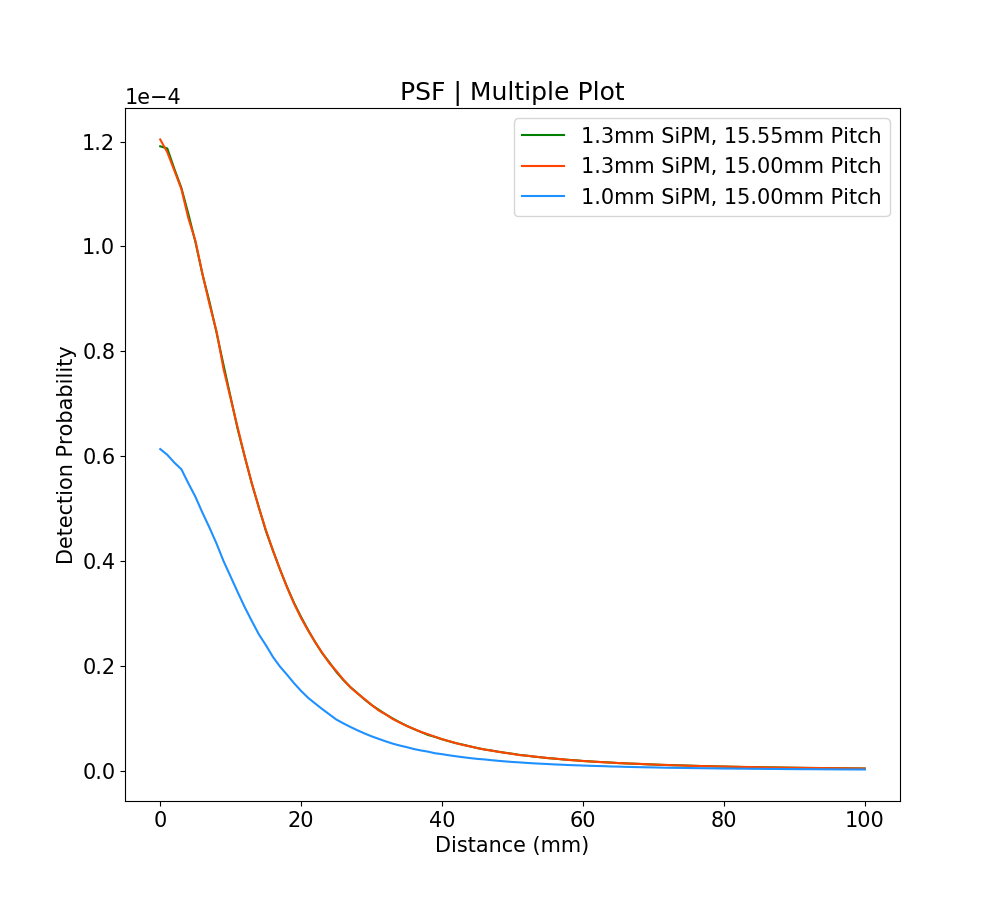

In [18]:
PSF_multiple([size1_3_pitch15_55.dbins[:101], size1_3_pitch15_00.dbins[:101], size1_0_pitch15_00.dbins[:101]],
             [size1_3_pitch15_55.probability.values[:101], size1_3_pitch15_00.probability.values[:101], size1_0_pitch15_00.probability.values[:101]],
             ["1.3mm SiPM, 15.55mm Pitch", "1.3mm SiPM, 15.00mm Pitch", "1.0mm SiPM, 15.00mm Pitch"],
             color_map_name = ["green", "orangered", "dodgerblue"],
             Title = "PSF | Multiple Plot")

### Size: 1.3mm, Pitch: 15.55mm | Size: 1.3mm, Pitch: 15.00mm | Size: 1.0mm, Pitch: 15.00mm. Mosaic Plot.

In [19]:
PSF_mosaic([size1_3_pitch15_55.dbins[:-1], size1_3_pitch15_00.dbins[:-1], size1_0_pitch15_00.dbins[:-1]],
           [size1_3_pitch15_55.probability.values, size1_3_pitch15_00.probability.values, size1_0_pitch15_00.probability.values],
           ["1.3mm SiPM, 15.55mm Pitch", "1.3mm SiPM, 15.00mm Pitch", "1.0mm SiPM, 15.00mm Pitch"],
           "inferno",
           """
           AAA
           BCD
           """,
           Title = "PSF | Mosaic Plot")

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplot_mosaic'

In [20]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.3
